In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/

import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [4]:
import pandas as pd
import json

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
train_file = '/Users/mac/Desktop/test/test.json'
with open(train_file,'r') as f:
        intents = json.load(f)
patterns = []
tags = []
output = len(intents['intents'])
for intent in intents['intents']:
    
    for pattern in intent['patterns']:
        tag = intent['tag']
        tags.append(tag)
        patterns.append(pattern)
df = pd.DataFrame({"sentence":patterns,"label":tags})

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df['label'] = df['label'].apply(lambda x : x-1)
# Display 10 random rows from the data.
df.tail(10)

Number of training sentences: 85



,sentence,label
75,What do I need to do to get an internship?,21
76,how to get internship,21
77,How many clubs are currently operating in this...,22
78,How many active clubs are there at this univer...,22
79,is there club,22
80,how do I join club in university,22
81,Thanks,23
82,Thank you,23
83,That's helpful,23
84,Thanks for the help,23


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

In [5]:
df.loc[df.label == 1][['sentence', 'label']]

,sentence,label
3,Does the program offer any scholarships to int...,1
4,is there scholarships to international applica...,1
5,how can I get scholarships,1




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [6]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

#gpt 3 , it can takes 1 hour to fine-tune
from transformers import GPT2Tokenizer , GPT2ForSequenceClassification,GPT2Config

model = GPT2ForSequenceClassification.from_pretrained('Deniskin/gpt3_medium',ignore_mismatched_sizes=True
                                                     ,num_labels = output, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False,) # Whether the model returns all hidden-states.
if torch.cuda.is_available():
    model.cuda()


# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)## using bert base model
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id


In [90]:
from transformers import GPT2Tokenizer , GPT2ForSequenceClassification

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2',num_labels = output)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
if torch.cuda.is_available():
    model.cuda()


Loading tokenizer...
ERROR! Session/line number was not unique in database. History logging moved to new session 1306
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's apply the tokenizer to one sentence just to see the output.


In [91]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  What are the requirements to enter the program?
Tokenized:  ['What', 'Ġare', 'Ġthe', 'Ġrequirements', 'Ġto', 'Ġenter', 'Ġthe', 'Ġprogram', '?']
Token IDs:  [2061, 389, 262, 5359, 284, 3802, 262, 1430, 30]


In [92]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  What are the requirements to enter the program?
Token IDs: [2061, 389, 262, 5359, 284, 3802, 262, 1430, 30]


In [ ]:
input_ids[0]

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Given that, let's choose MAX_LEN = 40 and apply the padding.

In [93]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences


MAX_LEN = 40

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 40 values...

Padding token: "<|endoftext|>", ID: 50256

Done.


In [ ]:
input_ids[0]

In [94]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [95]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [96]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [97]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [98]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 149 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)
transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)

==== First Transformer ====

transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

In [99]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [100]:
all_inputs = torch.tensor(input_ids)
all_label = torch.tensor(labels)
all_masks = torch.tensor(attention_masks)



# Create the DataLoader for our training set.
all_data = TensorDataset(all_inputs, all_masks, all_label)
all_sampler = RandomSampler(all_data)
all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=batch_size)


In [101]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 50

# Total number of training steps is number of batches * number of epochs.
total_steps = len(all_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

In [102]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)


# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
scheduler

In [86]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print(pred_flat)
    print(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [87]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [103]:
import random
import copy
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()
    best_model=None
    best_accuracy = 0
    # For each batch of training data...
    for step, batch in enumerate(all_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(all_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
    
        loss = outputs[0]


        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(all_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    if((eval_accuracy/nb_eval_steps) > best_accuracy):
        best_model = copy.deepcopy(model)
        best_model = best_model.cpu()
        best_accuracy = eval_accuracy/nb_eval_steps

print("")
print("Training complete!")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 6.80
  Training epcoh took: 0:00:24

Running Validation...
[18 18 18 18 11 18 18 11 18]
[16 16 21 23 23 20 10 14  4]
  Accuracy: 0.00
  Validation took: 0:00:01

======== Epoch 2 / 50 ========
Training...

  Average training loss: 4.54
  Training epcoh took: 0:00:27

Running Validation...
[12 22 22 16  0 12 18 18 22]
[16 16 21 23 23 20 10 14  4]
  Accuracy: 0.00
  Validation took: 0:00:01

======== Epoch 3 / 50 ========
Training...

  Average training loss: 3.54
  Training epcoh took: 0:00:26

Running Validation...
[16 22 22 18  0 22 18 18 18]
[16 16 21 23 23 20 10 14  4]
  Accuracy: 0.11
  Validation took: 0:00:01

======== Epoch 4 / 50 ========
Training...

  Average training loss: 3.33
  Training epcoh took: 0:00:27

Running Validation...
[12 12 22 16 14 16 18 18 22]
[16 16 21 23 23 20 10 14  4]
  Accuracy: 0.00
  Validation took: 0:00:00

======== Epoch 5 / 50 ========
Training...

  Average training loss: 3.00
 

Let's take a look at our training loss over all batches:

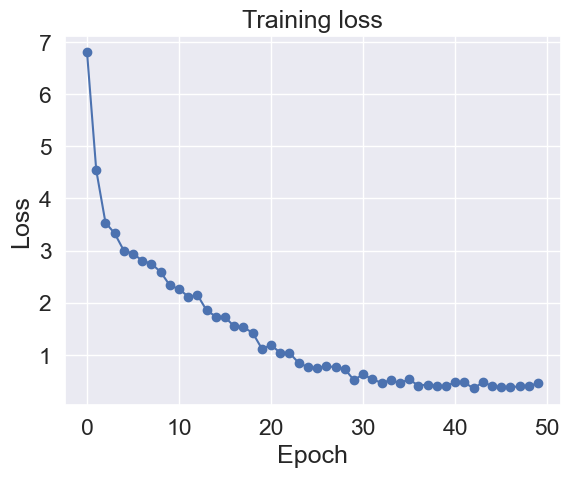

In [105]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)


# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
loss_values

In [ ]:
import plotly.express as px

f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [106]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './gptmodel_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = best_model.module if hasattr(best_model, 'module') else best_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./gptmodel_save/


('./gptmodel_save/tokenizer_config.json',
 './gptmodel_save/special_tokens_map.json',
 './gptmodel_save/vocab.json',
 './gptmodel_save/merges.txt',
 './gptmodel_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

In [108]:
from transformers import GPT2Tokenizer , GPT2ForSequenceClassification
output_dir = './gptmodel_save/'
model = GPT2ForSequenceClassification.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)


In [119]:
import torch
sent = 'What are the requirements to enter the program?'
model.eval()
max_length = 64
encoding = tokenizer(sent, return_tensors='pt', max_length=max_length, truncation=True)
b_input_ids = encoding['input_ids']
#token_type_ids = encoding['token_type_ids']
attention_mask = encoding['attention_mask']


In [120]:
outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_mask)

In [121]:
print(torch.argmax(outputs[0]))
torch.max(outputs[0])

tensor(15)


tensor(8.4376, grad_fn=<MaxBackward1>)